In [103]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import dateutil
import time
import tqdm
import obspy
import datetime
import os
import glob
import pytz

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = { 
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

from scipy.interpolate import interp1d

In [58]:
def read_PASSCAL_SEGY_headers(infile):
    """Function to read information within SEGY PASSCAL headers"""
    nTxtFileHeader=3200
    nBinFileHeader=400
    nTraceHeader=240
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        fid = gzip.open(infile, 'rb')
    fid.seek(0,2)
    filesize = fid.tell()
    startData = nTxtFileHeader+20
    fid.seek(startData)
    BinBuffer = fid.read(2)
    nt = int.from_bytes(BinBuffer, byteorder='big', signed=False)
    fid.seek(nTxtFileHeader+16)
    dt = int.from_bytes(fid.read(2), byteorder='big', signed=False)*1e-6
    if dt == 0.0:
        fs = 0.0
    else:
        fs = 1.0/dt
    # Getting UTC time first sample
    fid.seek(nTxtFileHeader+nBinFileHeader+156)
    year = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    day = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    hour = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    minute = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    second = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    print([year, day, hour, minute, second])
    TIME_BASIS_CODE = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    print(TIME_BASIS_CODE)
    micsec = int.from_bytes(fid.read(4), byteorder='big', signed=False)
    second = second+micsec*1e-6
    startTime = datetime.datetime.strptime("%s-%s"%(year,day),"%Y-%j") + datetime.timedelta(hours=hour, minutes=minute, seconds=second)
    print(startTime)
    if (TIME_BASIS_CODE) == 4 or (TIME_BASIS_CODE == 0):
        startTime = startTime.replace(tzinfo=pytz.utc)
    else:
        raise ValueError("Unknown time zone!")
    endTime = startTime + datetime.timedelta(seconds=nt*dt)
    nTraces = int((filesize - nTxtFileHeader - nBinFileHeader)/(nTraceHeader+nt*4))
    # Get the interregator info
    fid.seek(nTxtFileHeader+nBinFileHeader+232)
    ping_rate = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    recv_depth = int.from_bytes(fid.read(4), byteorder='big', signed=False)
    gauge_length = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    fid.close()
    return nt, fs, startTime, endTime, nTraces, (ping_rate, recv_depth, gauge_length)


def read_PASSCAL_segy(infile, nTraces, nSample, TraceOff=0):
    """Function to read PASSCAL segy raw data"""
    data = np.zeros((nTraces, nSample), dtype=np.float32)
    gzFile = False
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        gzFile = True
        fid = gzip.open(infile, 'rb')
    fid.seek(3600)
    # Skipping traces if necessary
    fid.seek(TraceOff*(240+nSample*4),1)
    # Looping over traces
    for ii in range(nTraces):
        fid.seek(240, 1)
        if gzFile:
            # np.fromfile does not work on gzip file
            BinDataBuffer = fid.read(nSample*4) # read binary bytes from file
            data[ii, :] = struct.unpack_from(">"+('f')*nSample, BinDataBuffer)
        else:
            data[ii, :] = np.fromfile(fid, dtype=">f", count=nSample)
    fid.close()
    return data

# Save and load event hdf5 files
def save_rawevent_h5(fn, data, info):
   """
   """
   info_copy = info.copy()
   with h5py.File(fn, 'w') as fid:
       fid.create_dataset('data', data=data)
       for key in info.keys():
           if isinstance(info[key], str):
               #fid['data'].attrs.modify(key, np.string_(info_copy[key]))
               fid['data'].attrs.modify(key, info_copy[key])
           else:
               fid['data'].attrs.modify(key, info_copy[key])

def load_rawevent_h5(fn):
    # with h5py.File(fn, 'r') as fid:
    #    data = fid['data'][:]
    #    info = {}
    #    for key in fid['data'].attrs.keys():
    #        info[key] = fid['data'].attrs[key]
    #    info2 = {}
    #    if 'begin_time' in info.keys():
    #        info2['begTime'] = dateutil.parser.parse(info['begin_time'])
    #    if 'end_time' in info.keys():
    #        info2['endTime'] = dateutil.parser.parse(info['end_time'])
    #    if 'event_time' in info.keys():
    #        info2['time'] = dateutil.parser.parse(info['event_time'])
    #    info2['nt'] = data.shape[0]
    #    info2['nx'] = data.shape[1]
    #    info2['dx'] = info['dx_m']
    #    info2['dt'] = info['dt_s']
    

    with h5py.File(fn, 'r') as fid:
        data = fid['data'][:]
        info = {}
        for key in fid['data'].attrs.keys():
            info[key] = fid['data'].attrs[key]
        if 'begin_time' in info.keys():
            info['begin_time'] = dateutil.parser.parse(info['begin_time'])
        if 'end_time' in info.keys():
            info['end_time'] = dateutil.parser.parse(info['end_time'])
        if 'event_time' in info.keys():
            info['event_time'] = dateutil.parser.parse(info['event_time'])
    return data, info
   

# This is used to convert the DAS phase shift to strain (in nano strain)
Ridgecrest_conversion_factor = 1550.12 / (0.78 * 4 * np.pi * 1.46 * 8)

In [125]:
DAS_info_df = pd.read_csv('/kuafu/EventData/Ridgecrest/das_info.csv')
ii_good_channel = DAS_info_df['index']

DAS_lat = DAS_info_df.latitude
DAS_lon = DAS_info_df.longitude

In [3]:
files = glob.glob('/kuafu/yinjx/Ridgecrest/Ridgecrest_test_event_20220715_M4.6/*.segy')
files.sort()

In [62]:
# This is to pull out the instrument information
for i_file, file in enumerate(files):
    nt_temp, fs, startTime_temp, endTime_temp, nTraces, interagator = read_PASSCAL_SEGY_headers(file)
    data0 = read_PASSCAL_segy(file, 1250, nt_temp, 0)
    # data0 = obspy.read(file)

    if i_file==0:
        startTime = startTime_temp
        nt = nt_temp
        data = data0
    else:
        nt = nt + nt_temp # update time samples
        data = np.concatenate([data, data0], axis=1)

    if i_file == len(files)-1:
        endTime = endTime_temp

    

[2022, 196, 1, 14, 10]
4
2022-07-15 01:14:10.092000
[2022, 196, 1, 14, 40]
4
2022-07-15 01:14:40.092000
[2022, 196, 1, 15, 10]
4
2022-07-15 01:15:10.092000
[2022, 196, 1, 15, 40]
4
2022-07-15 01:15:40.092000
[2022, 196, 1, 16, 10]
4
2022-07-15 01:16:10.092000
[2022, 196, 1, 16, 40]
4
2022-07-15 01:16:40.092000
[2022, 196, 1, 17, 10]
4
2022-07-15 01:17:10.092000
[2022, 196, 1, 17, 40]
4
2022-07-15 01:17:40.092000
[2022, 196, 1, 18, 10]
4
2022-07-15 01:18:10.092000
[2022, 196, 1, 18, 40]
4
2022-07-15 01:18:40.092000
[2022, 196, 1, 19, 10]
4
2022-07-15 01:19:10.092000
[2022, 196, 1, 19, 40]
4
2022-07-15 01:19:40.092000
[2022, 196, 1, 20, 10]
4
2022-07-15 01:20:10.092000
[2022, 196, 1, 20, 40]
4
2022-07-15 01:20:40.092000
[2022, 196, 1, 21, 10]
4
2022-07-15 01:21:10.092000
[2022, 196, 1, 21, 40]
4
2022-07-15 01:21:40.092000
[2022, 196, 1, 22, 10]
4
2022-07-15 01:22:10.092000
[2022, 196, 1, 22, 40]
4
2022-07-15 01:22:40.092000
[2022, 196, 1, 23, 10]
4
2022-07-15 01:23:10.092000
[2022, 196, 

In [63]:
startTime, endTime

(datetime.datetime(2022, 7, 15, 1, 14, 10, 92000, tzinfo=<UTC>),
 datetime.datetime(2022, 7, 15, 1, 29, 40, 92000, tzinfo=<UTC>))

In [119]:
# convert to strain rate
das_dt = 1 / fs
data_diff = np.diff(data, axis=1)/das_dt / 1e3 * Ridgecrest_conversion_factor # convert from nano strain rate to micro strain rate

# time information 
das_time = np.linspace(das_dt/2,nt*das_dt-das_dt/2,data_diff.shape[1])

data_diff = data_diff[ii_good_channel, :]

In [88]:
eq_time_str = str(obspy.UTCDateTime('2022/07/15 01:19:07.00'))

event_info_df = pd.DataFrame({'event_id': [40063391], 'event_time': [eq_time_str],
'latitude': [35.70917], 'longitude': [-117.58433], 'depth_km': [6.3], 'magnitude': [4.57], 'magnitude_type': ['mw'], 'source': ['scsn']})

event_info_df.to_csv('/kuafu/EventData/Ridgecrest/recent_40063391.csv', index=False)

In [122]:
eq_das_t0 = obspy.UTCDateTime(startTime)
eq_time_UTCDateTime = obspy.UTCDateTime(event_info_df.event_time[0])

t_begin = eq_time_UTCDateTime - eq_das_t0 - 30
t_end = eq_time_UTCDateTime - eq_das_t0 + 90


# segmented data
ii_time = (das_time >= t_begin) & (das_time <= t_end)
data_diff = data_diff[:, ii_time]
das_time = das_time[ii_time]   

# Downsample from 250 Hz to 100 Hz using interp
das_dt_ds = 0.01
das_time_ds = np.linspace(t_begin, t_end - das_dt_ds, 12000)

downsample_f = interp1d(das_time, data_diff, axis=1, bounds_error=False, fill_value=0)
data_diff_ds = downsample_f(das_time_ds)

In [123]:
event_data = data_diff_ds.T
event_info = {}
event_info['event_id'] = event_info_df.event_id[0]
event_info['event_time'] = eq_time_UTCDateTime.isoformat()
event_info['begin_time'] = (eq_time_UTCDateTime - 30).isoformat() + '+00:00'
event_info['end_time'] = (eq_time_UTCDateTime + 90).isoformat() + '+00:00'
event_info['latitude'] = event_info_df.latitude[0]
event_info['longitude'] = event_info_df.longitude[0]
event_info['depth_km'] = event_info_df.depth_km[0]
event_info['magnitude'] = event_info_df.magnitude[0]
event_info['magnitude_type'] = 'mwl'
event_info['source'] = 'scsn'
event_info['dt_s'] = das_dt_ds
event_info['dx_m'] = 8
event_info['das_array'] = 'Ridgecrest'

save_rawevent_h5('/kuafu/EventData/Ridgecrest/data/recent_40063391.h5', event_data, event_info)


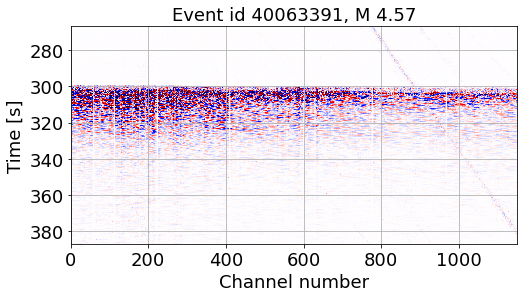

In [131]:
# Show data
fig, ax1 = plt.subplots(figsize=(8,4))
pclip=99.5
clipVal = np.percentile(np.absolute(event_data), pclip)
# Vx
ax1.imshow(event_data, 
        extent=[0, event_data.shape[1], das_time[-1], das_time[0]],
        aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_P[:, i_event], '--g', zorder=10)
# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_S[:, i_event], '-g', zorder=10)

ax1.set_xlabel("Channel number")
ax1.set_ylabel("Time [s]")
ax1.grid()
ax1.set_title(f"Event id {event_info['event_id']}, M {event_info['magnitude']}")

plt.savefig('/kuafu/EventData/Ridgecrest/data/figures/recent_40063391.png', bbox_inches='tight')


In [142]:
DAS_channel_num = event_data.shape[1]

# calculate the theoretical TT
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
tt_output_dir = '/kuafu/EventData/Ridgecrest/theoretical_arrival_time'
travel_time_table_file = tt_output_dir + '/travel_time_table.npz'


# The TTT calculated or already exists, directly load it.
temp = np.load(travel_time_table_file)
distance_grid = temp['distance_grid']
depth_grid = temp['depth_grid']
tavel_time_p_grid = temp['tavel_time_p_grid']
tavel_time_s_grid = temp['tavel_time_s_grid']

# build the interpolation function
from scipy.interpolate import interp2d, griddata
#grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

ii = ~np.isnan(tavel_time_p_grid) # ignore the nan
# interp_f_p = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_p_grid[ii], kind='linear')
# interp_f_s = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_s_grid[ii], kind='linear')


# estimate the arrival time of each earthquake to all channels
P_arrival = np.zeros(DAS_channel_num)
S_arrival = np.zeros(DAS_channel_num)
distance_to_source = locations2degrees(DAS_lat, DAS_lon, event_info_df.latitude[0], event_info_df.longitude[0])

P_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_p_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))
S_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_s_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))

# 30s is the event time 
P_arrival = 30 + P_arrival + 0.75
S_arrival = 30 + S_arrival + 1.4


In [148]:
# store the travel time information

DAS_info_df['P_arrival'] = P_arrival
DAS_info_df['S_arrival'] = S_arrival

DAS_info_df.to_csv(tt_output_dir + f"/1D_tt_{event_info['event_id']}.csv", index=False)

Text(0.5, 1.0, 'Event id 40063391, M 4.57')

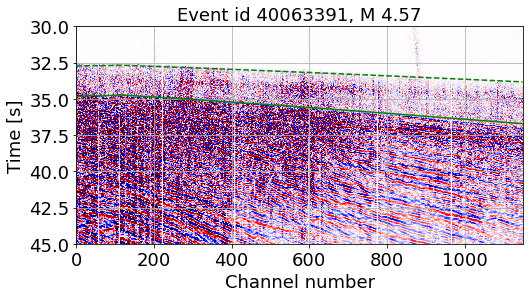

In [146]:
# Show data
fig, ax1 = plt.subplots(figsize=(8,4))
pclip=99.5
clipVal = np.percentile(np.absolute(event_data), pclip)
# Vx
ax1.imshow(event_data, 
        extent=[0, event_data.shape[1], 120, 0],
        aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

ax1.plot(np.arange(0, event_data.shape[1]), P_arrival, '--g', zorder=10)
ax1.plot(np.arange(0, event_data.shape[1]), S_arrival, '-g', zorder=10)

ax1.set_xlabel("Channel number")
ax1.set_ylabel("Time [s]")
ax1.grid()
ax1.set_ylim(30, 45)
ax1.invert_yaxis()
ax1.set_title(f"Event id {event_info['event_id']}, M {event_info['magnitude']}")

In [109]:
event_info_df.event_id[0]

40063391

(280.0, 320.0)

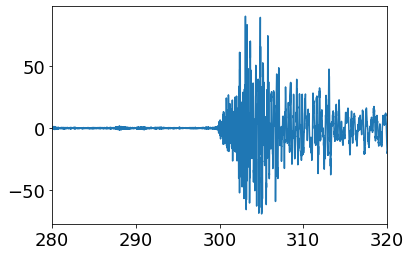

In [77]:
temp0 = data_diff[500, :]

plt.plot(das_time, temp0)
#plt.plot(das_time, temp1)
plt.xlim(280, 320)

In [82]:
event_data.shape

(232499, 1250)